# Finding Anomalies for an Entire Era
This notebook is for compiling an Excel file detailing all of the anomalies in a single era. 

Specify the Era

1. Load the appropriate model
2. Import all runs/lumisections that pass the DCS flags
3. Predict on the lumisections
4. Loop over each run
    * Split the long combined lumisection, data, and predictions arrays with their respective run number
    * Store the predictions with the specific run in a dictionary
    * Keep a running list of each dictionary
5. Loop over each run
    * Calculate the losses and binary losses (Do this in separate loop so we can change the loss threshold)
6. Loop over each run and analyze the anomalies
    * Try to figure out a data storage format that we can run through the normal Excel creation format
7. Create an plot for each anomalous lumisection

In [1]:
%%time
# imports

import os
import sys
import json
import time
import joblib
import importlib
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# thisdir = os.getcwd()
# topdir = os.path.abspath(os.path.join(thisdir, '../../../'))
# sys.path.append(topdir)

# import tools.iotools as iotools
# import tools.dftools as dftools
import plottools as plottools
# from tools.dataloadertools import MEDataLoader

# from studies.clusters_2024.preprocessing.preprocessor import make_default_preprocessor
# from studies.clusters_2024.nmf.modeldefs.nmf2d 
from nmf2d import NMF2D
# from studies.clusters_2024.nmf.nmf_training import find_files, train

import functions
importlib.reload(functions);
from functions import *
# from functions import save_digis_png
# from functions import extract_data_2d
# #from functions import extract_data_2d_multi_lumis
# from functions import plot_fpix_digi
# from functions import remove_cross
# from functions import add_cross
# from pyarrow.parquet import ParquetDataset
    
#Used to load an extension that can skip the remaining execution of a cell. 
#Used to skip the training so we don't constantly retrain a model
%load_ext skip_kernel_extension
%reload_ext skip_kernel_extension

optimized_powerGroupStringsList = np.array(['FPix_BmO_D3_ROG4','FPix_BmO_D2_ROG4','FPix_BmO_D1_ROG4','FPix_BmO_D3_ROG3','FPix_BmO_D2_ROG3','FPix_BmO_D1_ROG3','FPix_BmO_D3_ROG2','FPix_BmO_D2_ROG2','FPix_BmO_D1_ROG2','FPix_BmO_D3_ROG1','FPix_BmO_D2_ROG1','FPix_BmO_D1_ROG1','FPix_BmI_D3_ROG1','FPix_BmI_D2_ROG1','FPix_BmI_D1_ROG1','FPix_BmI_D3_ROG2','FPix_BmI_D2_ROG2','FPix_BmI_D1_ROG2','FPix_BmI_D3_ROG3','FPix_BmI_D2_ROG3','FPix_BmI_D1_ROG3','FPix_BmI_D3_ROG4','FPix_BmI_D2_ROG4','FPix_BmI_D1_ROG4','FPix_BpO_D1_ROG4','FPix_BpO_D2_ROG4','FPix_BpO_D3_ROG4','FPix_BpO_D1_ROG3','FPix_BpO_D2_ROG3','FPix_BpO_D3_ROG3','FPix_BpO_D1_ROG2','FPix_BpO_D2_ROG2','FPix_BpO_D3_ROG2','FPix_BpO_D1_ROG1','FPix_BpO_D2_ROG1','FPix_BpO_D3_ROG1','FPix_BpI_D1_ROG1','FPix_BpI_D2_ROG1','FPix_BpI_D3_ROG1','FPix_BpI_D1_ROG2','FPix_BpI_D2_ROG2','FPix_BpI_D3_ROG2','FPix_BpI_D1_ROG3','FPix_BpI_D2_ROG3','FPix_BpI_D3_ROG3','FPix_BpI_D1_ROG4','FPix_BpI_D2_ROG4','FPix_BpI_D3_ROG4'])
#A list of all of the quarters of the detector
QUARTERS = np.array([['FPix_BmI_D3_ROG1','FPix_BmI_D3_ROG2','FPix_BmI_D3_ROG3','FPix_BmI_D3_ROG4','FPix_BmI_D2_ROG1','FPix_BmI_D2_ROG2','FPix_BmI_D2_ROG3','FPix_BmI_D2_ROG4','FPix_BmI_D1_ROG1','FPix_BmI_D1_ROG2','FPix_BmI_D1_ROG3','FPix_BmI_D1_ROG4'], ['FPix_BmO_D3_ROG1','FPix_BmO_D3_ROG2','FPix_BmO_D3_ROG3','FPix_BmO_D3_ROG4','FPix_BmO_D2_ROG1','FPix_BmO_D2_ROG2','FPix_BmO_D2_ROG3','FPix_BmO_D2_ROG4','FPix_BmO_D1_ROG1','FPix_BmO_D1_ROG2','FPix_BmO_D1_ROG3','FPix_BmO_D1_ROG4'], ['FPix_BpI_D1_ROG1','FPix_BpI_D1_ROG2','FPix_BpI_D1_ROG3','FPix_BpI_D1_ROG4','FPix_BpI_D2_ROG1','FPix_BpI_D2_ROG2','FPix_BpI_D2_ROG3','FPix_BpI_D2_ROG4','FPix_BpI_D3_ROG1','FPix_BpI_D3_ROG2','FPix_BpI_D3_ROG3','FPix_BpI_D3_ROG4'], ['FPix_BpO_D1_ROG1','FPix_BpO_D1_ROG2','FPix_BpO_D1_ROG3','FPix_BpO_D1_ROG4','FPix_BpO_D2_ROG1','FPix_BpO_D2_ROG2','FPix_BpO_D2_ROG3','FPix_BpO_D2_ROG4','FPix_BpO_D3_ROG1','FPix_BpO_D3_ROG2','FPix_BpO_D3_ROG3','FPix_BpO_D3_ROG4']])

CPU times: user 1.4 s, sys: 1.06 s, total: 2.46 s
Wall time: 2.94 s


|         Era         | C | D | E | E | F |   F  |   G  |   H  |   I  |   I  |
|:-------------------:|:-:|:-:|:-:|:-:|:-:|:----:|:----:|:----:|:----:|:----:|
|       Version       | 1 | 1 | 1 | 2 | 1 |   1  |   1  |   1  |   1  |   2  |
|         Part        | 1 | 1 | 1 | 1 | 1 |   2  |   1  |   1  |   1  |   1  |
|        Model        | C | C | C | C | C | F_p2 | F_p2 | F_p2 | F_p2 | F_p2 |
| Loss 4e5 Cutoff 40% | ✓ | ✓ | ✓ | ✓ | ✓ | ✓    | ✓    | ✓    | ✓    | ✓    |
| Loss 7e5 Cutoff 50% | ✓ | ✓ | ✓ | ✓ | ✓ | ✓    | ✓    | ✓    | ✓    | ✓    |

# Important Variables

In [2]:
#This one variable determines the entire era to import and detect anomalies on
ERA = "C" #This is the era you want to TEST on. I believe I've successfully decoupled this from the model importing.
VERSION = 2
YEAR = 2025
MODEL_PART = 1 #REMEMBER TO SET THIS TO 2 IF YOU WANT TO TEST ON THE SECOND HALF OF ERA F!!!!!
NUM_COMPONENTS = 5
MODEL_NAME = f'nmf_model_era{YEAR}{ERA}_v{VERSION}_p{MODEL_PART}_{NUM_COMPONENTS}_Components.pkl'
MODEL_NAME = f'nmf_model_era{YEAR}{ERA}_v{1}_p{2}_{NUM_COMPONENTS}_Components_Attempt_4.pkl'

if ERA=="F": print("REMEMBER TO SET MODEL_PART TO 2 IF YOU WANT TO TEST ON THE SECOND HALF OF ERA F!!")
if ERA!="F" and YEAR==2024 and MODEL_PART!=1: raise Exception("Only 2024 ERA F has a MODEL_PART greater than 1!!!")
if ERA!="C" and YEAR==2025 and MODEL_PART!=2: raise Exception("Only 2025 ERA C has a MODEL_PART greater than 1!!!")

# #Important variables for the entire notebook
FORCE_PREDICT = False #whether or not to force the model to repredict. WARNING: Predicting takes a VERY long time. ~30mins for 25,000 lumisections
LOSS_THRESHOLD = 9e5 #The threshold for the binary loss. Determines whether or not the loss is large enough to count as anomalous
ANOMALY_CUTOFF = .4 #The percentage of a powergroup that must be out before we count it as an anomaly and record that specific lumisection
#Plotting Globals
DO_PLOTTING = False #Whether or not to plot EVERY anomalous lumisection in this era. WARNING: Takes a long time. ~13mins for 93 anomalies
SAVE_FIGS = False #Whether or not to also SAVE the plot of every anomalous lumisection. DO_PLOTTING must also be True for the images to be saved
SHOW_FIGS = False #Whether or not to also SHOW the plot of every anomalous lumisection. DO_PLOTTING must also be True for the images to be showed. It is possible to show and not save the images

#Some light calculation of important variables
file = f'/eos/user/a/alaperto/TkDQM/Devel/NMFolder/data/ZeroBias-Run{YEAR}{ERA}-PromptReco-v{VERSION}-DQMIO-PixelPhase1-Phase1_MechanicalView-PXForward-clusters_per_SignedDiskCoord_per_SignedBladePanelCoord_PXRing_1.parquet'
oms_json = f'omsdata/omsdata_Run{YEAR}{ERA}-v{VERSION}.json'
ring_num = int(file[-9]) #The -9th character is ALWAYS the ring number for our data

#The directory name to use for 
#'NMF Folder/Excel Anomaly Files/DIR_NAME/excel files' and 'NMF Folder/images/DIR_NAME/images'
DIR_NAME = f"Era_{YEAR}{ERA}_LossThresh_{np.format_float_scientific(LOSS_THRESHOLD, trim='-')}_AnomalyCutoff_{int(ANOMALY_CUTOFF*100)}%_{NUM_COMPONENTS}_Components" 

## 1. Load the Model

In [3]:
#or load nmf an already produced one
#Check if a model with the version number exists
# nmf_file = f'models/PXRing_1/nmf_model_era{MODEL_ERA}_p{MODEL_PART}.pkl'
# if not os.path.exists(nmf_file):
# #if not, use the one without the part number
#     nmf_file = f'models/PXRing_1/nmf_model_era{MODEL_ERA}.pkl'
# #If we don't already have a model then fall back to era C
# if not os.path.exists(nmf_file):
#     nmf_file = f'models/PXRing_1/nmf_model_eraC.pkl'
#     print(f"No Model Found for Era {MODEL_ERA}! Falling Back to Era C.")

# #Screw this, I am just hard coding the models for each Era and part number
# if (ERA=='C' or ERA=='D' or ERA=='E' or ERA=='F') and MODEL_PART==1:
#     nmf_file = f'models/PXRing_1/nmf_model_eraC.pkl'
# elif (ERA=='F' and MODEL_PART==2) or (ERA=='G' or ERA=='H' or ERA=='I'):
#     nmf_file = f'models/PXRing_1/nmf_model_eraF.pkl'
# else:
#     print("INVALID COMBO OF ERA AND MODEL PARTS")

#Screw this AGAIN, all attempts at standardizing a model name format have failed
#I'll just have the user specify the specific model to load at the start in the Important Variables

nmf_file = f'models/PXRing_{ring_num}/{MODEL_NAME}'

nmf = joblib.load(nmf_file)

print(f"The Era is {ERA}!")
print(f"Loaded Model: {nmf_file}")
print(f"Model Shape: {nmf.xshape}")

The Era is C!
Loaded Model: models/PXRing_1/nmf_model_era2025C_v1_p2_5_Components_Attempt_4.pkl
Model Shape: [88, 48]


## 2. Import all runs/lumisections that pass the DCS flags
Import the entire era at once so we only have to go to the disk once. 

Use the OMS JSON to filter only the lumisections that pass the DCS flags. Helps to reduce unnecessary predictions on bad lumisections

In [4]:
%%time
#Any logic for when parts of the detector are disabled. 
extra_filters = []
#Logic for Era F part 2 and 2025 Era C part 1/2
if ERA == "F" and MODEL_PART == 1 and YEAR == 2024:
    extra_filters.append(('run_number', '<', 382799))
elif ERA == "F" and MODEL_PART == 2 and YEAR == 2024:
    extra_filters.append(('run_number', '>=', 382799))
elif ERA == "C" and VERSION == 1 and MODEL_PART == 1 and YEAR == 2025:
    extra_filters.append(('run_number', '<=', 392668))
elif ERA == "C" and VERSION == 2 and MODEL_PART == 1 and YEAR == 2025:
    extra_filters.append(('run_number', '>', 392668))
    extra_filters.append(('run_number', '<', 393512))#Everything past this is a special machine development run
#Testing the function to import AND filter an entire era at once
multi_lumi_data, all_runs, lumis, df = extract_data_whole_era(file, oms_json, extra_filters=extra_filters)
del df
all_runs, indices = np.unique(all_runs, return_index=True)
indices = indices[1:] #The first index in indices is always 0, since the first number is always unique, so we discard that. 
print(f"There are {len(all_runs)} Runs and {len(lumis)} Lumisections that Pass All DCS Flags: \n", all_runs)
#Optional if you'd like to see how many TOTAL runs there are, as most runs are entirely disqualified due to DCS Flags. 
# dataset = ParquetDataset(file).read().to_pandas()
# all_runs = np.array(dataset["run_number"].unique())
# print(f"There are {len(all_runs)} Total Available Runs: \n", all_runs)

There are 27 Runs and 20942 Lumisections that Pass All DCS Flags: 
 [393111 393125 393126 393127 393128 393129 393147 393168 393169 393170
 393171 393240 393273 393274 393275 393276 393331 393346 393347 393376
 393377 393378 393445 393446 393447 393448 393461]
CPU times: user 7.57 s, sys: 7 s, total: 14.6 s
Wall time: 15.8 s


## 3. Predict on the lumisections

In [5]:
%%time
FORCE_PREDICT = FORCE_PREDICT  #Force a prediction to occur and overwrite the previous predictions

#Remove the cross so we can predict on it
multi_lumi_data_no_cross = remove_cross(multi_lumi_data)

#Save predictions array to a file since they take so long to produce
filename = f"Era_{YEAR}{ERA}_ver_{VERSION}_Ring_{ring_num}_{len(lumis)}_Lumisections_Predictions_No_Cross"
#Save the predictions to the directory of the model that did the predictions
prediction_dir = nmf_file[0:-4] + '/predictions'
#If we don't already have a prediction directory then make it
if not os.path.exists(prediction_dir): os.makedirs(prediction_dir)
prediction_filepath = prediction_dir + f"/{filename}"

print(prediction_filepath)

if os.path.exists(prediction_filepath + '.npy') and FORCE_PREDICT == False:
    print(f"Predictions Already Exist! Loading predictions from {prediction_filepath}")
    mes_pred = np.load(prediction_filepath + '.npy')
    print(f"Predictions with {mes_pred.shape} shape loaded from {prediction_filepath}.npy")
else:
    if FORCE_PREDICT: 
        print(f"FORCE_PREDICT is TRUE. Will overwrite the predictions file at {prediction_filepath}!")
    else:
        print("Predictions Don't Already Exist for This Model and Era! Starting Prediction. ")

    #Predict on the data
    print(f'Predicting...')
    start_time = time.time()
    mes_pred = nmf.predict(multi_lumi_data_no_cross)
    np.save(prediction_filepath, mes_pred)
    print(f"Done Predicting in {time.time() - start_time} Seconds!\n")

models/PXRing_1/nmf_model_era2025C_v1_p2_5_Components_Attempt_4/predictions/Era_2025C_ver_2_Ring_1_20942_Lumisections_Predictions_No_Cross
Predictions Already Exist! Loading predictions from models/PXRing_1/nmf_model_era2025C_v1_p2_5_Components_Attempt_4/predictions/Era_2025C_ver_2_Ring_1_20942_Lumisections_Predictions_No_Cross
Predictions with (20942, 88, 48) shape loaded from models/PXRing_1/nmf_model_era2025C_v1_p2_5_Components_Attempt_4/predictions/Era_2025C_ver_2_Ring_1_20942_Lumisections_Predictions_No_Cross.npy
CPU times: user 443 ms, sys: 1.01 s, total: 1.45 s
Wall time: 7.36 s


## 4. Loop over each run
    * Split the long combined lumisection, data, and predictions arrays with their respective run number
    * Store the predictions with the specific run in a dictionary
    * Keep a running list of each dictionary

In [6]:
%%time
#Verbose=0: No prints. Verbose=1: Some prints. Verbose>=2: Some very long prints
verbose = 0

#Split the long combined arrays of the lumisections, the data, and the predictions
lumisections = np.split(lumis, indices)
data_arr = np.split(multi_lumi_data_no_cross, indices)
pred_arr = np.split(mes_pred, indices)

#print(pred_arr[1].shape)

#Now that we have our data split into arrays by run number, we can loop over the unique run numbers 
#and generate our data_dicts and put them in a data_dict_list. So it is in a format ready to be used to calculate the losses and anomalies. 
#Create a list to store all of the lumisections and predictions
data_dict_list = list(np.empty_like(all_runs)) 
for index, run_number in enumerate(all_runs):
    data_dict = {}
    data_dict["run_number"] = run_number
    data_dict["lumisections"] = lumisections[index]
    data_dict["data"] = data_arr[index]
    data_dict["predictions"] = pred_arr[index]
    #Add the cross into the predictions and data
    data_dict["data_cross"] = add_cross(data_arr[index])
    data_dict["predictions_cross"] = add_cross(pred_arr[index])
    
    #Add this run to the data dict list
    data_dict_list[index] = data_dict    
    #Printing
    if verbose>0:
        print(f"Run Number: {run_number}")
        print(f"\tThere are {len(lumisections[index])} Extracted Lumisections:\n\t{lumisections[index]}\n")
    if verbose>1:
        print(data_dict)
        
if verbose>0:
    print(data_dict_list[0])
elif verbose>1:
    print(data_dict_list)

CPU times: user 5.67 s, sys: 331 ms, total: 6 s
Wall time: 6.04 s


## 5. Loop over each run
    * Calculate the losses and binary losses (Do this in separate loop so we can change the loss threshold)

In [7]:
%%time

loss_threshold = LOSS_THRESHOLD

#Loop over each data dictionary in the list and calculate the losses and binary losses. 
#Add these to the dictionaries as we go along. 
for index, data_dict in enumerate(data_dict_list):
    #Extract the needed info from the data_dict
    multi_lumi_data_no_cross = data_dict["data"]
    mes_pred = data_dict["predictions"]
    
    #Calculate losses
    losses = np.square(multi_lumi_data_no_cross - mes_pred)
    losses_binary = (losses > loss_threshold).astype(int)
    
    #Add the crosses back
    losses_cross = add_cross(losses)
    losses_binary_cross = add_cross(losses_binary)
    
    #Add new entries to the data_dict
    #This will automatically update the dictionaries in the data_dict_list
    data_dict["losses"] = losses_cross
    data_dict["losses_binary"] = losses_binary_cross

CPU times: user 5.42 s, sys: 1.24 s, total: 6.66 s
Wall time: 6.7 s


## 6. Loop over each run and analyze the anomalies. 

### Analyze Each Lumisection of Each Run for Anomalies

In [8]:
%%time

testingtime = False
verbose = False

#Flag a lumisection if more than anomaly_cutoff percentage of bins are on
anomaly_cutoff = ANOMALY_CUTOFF
#Create lists for tracking the anomalous lumisections in all of the runs
all_anomalous_runs = []
all_anomalous_lumisections = []
all_anomalous_powergroups = []

for i, data_dict in enumerate(data_dict_list):
    #Extract the required info from the data_dict
    run_number = data_dict["run_number"]
    lumisections = data_dict["lumisections"]
    losses_binary_cross = data_dict["losses_binary"]
    
    #Currently a list of anomalous lumisections and their powergroups
    #These arrays are prevented from getting out of sync by still appending 
    #the anomalous lumisection even if that lumisection was already marked bad with a different powergroup
    anomalous_lumisections = []
    anomalous_powergroups = []

    for index, lumisection in enumerate(lumisections):
        if verbose: print(f"Index: {index} \t Lumisection: {lumisection}")

        for j, powergroup in enumerate(optimized_powerGroupStringsList):
            #if not testingtime: print(f"Power Group String: {powergroup}")
            powerGroupSlice, diskSlice = powerGroupToIndex(powergroup)

            #Access each power group in each lumisection and see if more than 50% of the bins are on
            #A bit ugly, but this was the fastest way I found. Saved about .1 seconds over saving the powergroup data to another variable. 
            if int(np.sum(losses_binary_cross[index, powerGroupSlice, diskSlice].flatten())) >= int(anomaly_cutoff * losses_binary_cross[index, powerGroupSlice, diskSlice].flatten().size):
                if verbose: print(f"Anomalous Power Group: {powergroup} \t in Lumisection: {lumisection} \t with Binary Sum: {np.sum(powerGroup_data)}")
                all_anomalous_runs.append(run_number)
                anomalous_lumisections.append(lumisection)
                anomalous_powergroups.append(powergroup)
                
            #This is used to pull out specific lumisection and check their binary loss occupancy
#             if run_number == 381544 and lumisection == 1861:
#                 print(f"Powergroup: {powergroup}")
#                 print(f"Powergroup Size:{losses_binary_cross[index, powerGroupSlice, diskSlice].flatten().size}")
#                 print(f"Sum of Binary Loss:{np.sum(losses_binary_cross[index, powerGroupSlice, diskSlice].flatten())}\n")

                if verbose: save_digis_png(losses_binary_cross[index], testing_ring_num, lumisection, 1)
    #Update the data_dict with the anomalous lumisections and powergroups
    #I don't have a plan for them currently, but it could be useful
    data_dict["anomalous_lumisections"] = np.array(anomalous_lumisections)
    data_dict["anomalous_powergroups"] = np.array(anomalous_powergroups)
    
    #EXTEND the anomalous lumisections and powegroups to the ALL list. Extend keeps the list flat
    all_anomalous_lumisections.extend(anomalous_lumisections)
    all_anomalous_powergroups.extend(anomalous_powergroups)
    
# print(all_anomalous_runs)
# print(all_anomalous_lumisections)
# print(all_anomalous_powergroups)
# print(data_dict_list[-2])
num_anomalous_lumisections, all_anomalous_lumisections_unique = calcNumAnomalousLumisections(data_dict_list)
print(f"There Were {num_anomalous_lumisections} Anomalous Lumisections Found in Era {ERA} Version {VERSION} From Run {all_runs[0]} to Run {all_runs[-1]}!!")
print("For some reason the above number can disagree with the sum of the Num_LS column in Excel. But they are never far off. ")
#Might happen due to lumisections appearing twice in the excel file. Like when a single lumisection has both a single disk anomaly and a multi disk anomaly
#The lumisection could be double counted. There may be more cases where this happens. 

There Were 734 Anomalous Lumisections Found in Era C Version 2 From Run 393111 to Run 393461!!
For some reason the above number can disagree with the sum of the Num_LS column in Excel. But they are never far off. 
CPU times: user 24.4 s, sys: 37.2 ms, total: 24.4 s
Wall time: 24.5 s


## Identify Anomaly Types
This section will identify runs in lumisections that stay the same then compare the powergroups and see if there are any multi-disk anomalies. 

If there are no repeating lumisections, then it is just a single disk anomaly. 

### Create a file summarizing all lumisections and their anomalies
#### Run_Number    Lumisection    PRT    Disk    Ring_Num    Anomaly_Type

In [9]:
%%time
#Identify multi disk anomalies
verbose = 0
#Create a pandas dataframe that we can use to track EACH anomalous lumisection in each run
headers = ["Run_Number", "Lumisection", "Powergroup", "Disk", "Ring_Num", "Anomaly_Type"]
all_detailed_anomaly_df = pd.DataFrame(columns=headers)

#Loop over each data dict in the data dict list
for index, data_dict in enumerate(data_dict_list):
    #Extract the relavant information
    run_number = data_dict["run_number"]
    anomalous_lumisections = data_dict["anomalous_lumisections"]
    anomalous_powergroups = data_dict["anomalous_powergroups"]
    
    #If there are no anomaous lumisections or powergroups then stop this iteration
    if anomalous_lumisections.size == 0 or anomalous_powergroups.size == 0:
        continue
    

    #Create dataframe of anomalous lumisections and powergroups
    anomaly_df = pd.DataFrame({"lumisections": anomalous_lumisections, "powergroups": anomalous_powergroups})

    if verbose>0: print("Anomaly Dataframe: \n", anomaly_df, '\n')

    #Create unique arrays to pare down duplicate data
    anomalous_lumisections_unique = np.unique(anomalous_lumisections)


    #Create a list of dictionaries for easier saving to text
    dictList = np.empty_like(anomalous_lumisections_unique, dtype=dict)

    detailed_anomaly_df = pd.DataFrame(columns=headers)

    # print("AHHHHHHH\n", detailed_anomaly_df)
    if verbose>0: print('-----------------------------------------')
    #Loop over each unique lumisection
    for index, lumisection in enumerate(anomalous_lumisections_unique):
        #These values are the same for single/multi disk anomalies
        dataDict = dict.fromkeys(headers)
        dataDict["Run_Number"] = run_number
        dataDict["Lumisection"] = lumisection
        dataDict["Ring_Num"] = ring_num

        #Get the lumisection and all of the anomaly powergroups
        #If there is only one powergroup, mark it Single Disk, preparing the detailed Pandas anomaly dataframe, then move on
        #If there is multiple powergroups, iterate through each pair, breaking on the first Multi-disk anomaly after preparing the detailed Pandas anomaly dataframe
        #If there is no Multi-disk anomaly despite there being multiple anomalies in one lumisection, prepare the detailed Pandas anomaly dataframe with EACH anomaly


        dataframe = anomaly_df[anomaly_df["lumisections"] == lumisection]
        if verbose>0: print(dataframe, '\n')
        powergroups = dataframe["powergroups"].to_list()
        if verbose>0: print(f"Powergroups: {powergroups}")

        #If there are 12 anomalous powergroups in one lumisection, check if it's a whole quarter out
        if len(powergroups) == 12:
            for quarter in QUARTERS:
                #If all of the powergroups are in one quarter, then we can save and break early
                if np.all(np.isin(powergroups, quarter)):
                    #Fill in the data dict
                    m_or_p, I_or_O, disk_number, part_number = analyzePowerGroupString(powergroups[0])
                    dataDict["Powergroup"] = ':'.join(powergroups) #Make a string of each powergroup separated by colons. A char not typically used in csv's. 
                    dataDict["Disk"] = "-1:-2:-3" if disk_number < 0 else "1:2:3"
                    dataDict["Anomaly_Type"] = "Whole Quarter"
                    dataFrame = pd.Series(dataDict).to_frame().T
                    #print(dataFrame)
                    detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
                    #break out of this for loop for the quarters
                    break
            #then continue to the next unique anomaly
            continue

        #If there is only one powergroup, mark it as a Single disk anomaly
        if len(powergroups) == 1:
            #Fill in the data dict
            m_or_p, I_or_O, disk_number, part_number = analyzePowerGroupString(powergroups[0])
            dataDict["Powergroup"] = powergroups[0]
            dataDict["Disk"] = disk_number
            dataDict["Anomaly_Type"] = "Single Disk"
            #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
            #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
            if verbose>1: print("DATA DICT:", dataDict)
            dataFrame = pd.Series(dataDict).to_frame().T
            #print(dataFrame)
            detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
            #continue to the next loop
            continue

        #If there is more than one anomalous powergroup in that lumisection and it's NOT the whole quarter out
        all_powergroup_combos = itertools.combinations(powergroups, 2)
        #Loop over all pairs of powergroups and search for multi-disk anomalies
        dataDictList = [] #Create a list to store all of the possible Single Disk anomalies in case there are multiple anomalies but no Multi Disk anomaly
        for powergroup_combo in all_powergroup_combos:
            #print("ADFJNDKFN", powergroup_combo)
            anomaly_type = powerGroupsToAnomalyType(powergroup_combo[0], powergroup_combo[1])
            #Extract relevant information
            m_or_p_one, I_or_O_one, disk_number_one, part_number_one = analyzePowerGroupString(powergroup_combo[0])
            m_or_p_two, I_or_O_two, disk_number_two, part_number_two = analyzePowerGroupString(powergroup_combo[1])
            if anomaly_type == "Multi Disk":
                #Fill in the data dict
                dataDict["Powergroup"] = powergroup_combo[0] + ':' + powergroup_combo[1]
                dataDict["Disk"] = str(disk_number_one) + ':' + str(disk_number_two)
                dataDict["Anomaly_Type"] = "Multi Disk"
                #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
                #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
                if verbose>1: print("DATA DICT:", dataDict)
                dataFrame = pd.Series(dataDict).to_frame().T
                #print(dataFrame)
                detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
                #break
            else:
                #Fill in a data dict for each anomaly
                dataDict["Powergroup"] = powergroup_combo[0]
                dataDict["Disk"] = str(disk_number_one)
                dataDict["Anomaly_Type"] = "Single Disk"
                #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
                #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
                if verbose>1: print("DATA DICT ONE:", dataDict)
                dataFrame = pd.Series(dataDict).to_frame().T
                if verbose>1: print(dataFrame)
                detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])

                #Fill in second data dict
                dataDict["Powergroup"] = powergroup_combo[1]
                dataDict["Disk"] = str(disk_number_two)
                dataDict["Anomaly_Type"] = "Single Disk"
                #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
                #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
                if verbose>1: print("DATA DICT TWO:", dataDict)
                dataFrame = pd.Series(dataDict).to_frame().T
                #print(dataFrame)
                detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
            if verbose>0: print('----------------------------------------')
        if verbose>0: print('-----------------------------------------')

    #Remove all exact duplicate rows
    detailed_anomaly_df = detailed_anomaly_df.drop_duplicates()
    if verbose>0: print('\n\n')
    #print(detailed_anomaly_df)
    all_detailed_anomaly_df = pd.concat([all_detailed_anomaly_df, detailed_anomaly_df])
    #ensure the directory is created
    if not os.path.exists(f"Anomaly Excel Files/{DIR_NAME}"): os.makedirs(f"Anomaly Excel Files/{DIR_NAME}")
    detailed_anomaly_df.to_excel(f"Anomaly Excel Files/{DIR_NAME}/Era_{YEAR}{ERA}_Run_{run_number}_Anomalies_Raw.xlsx", index=False, engine='openpyxl')

CPU times: user 961 ms, sys: 30.8 ms, total: 992 ms
Wall time: 1.79 s


In [10]:
%%time
# Identify and condense runs of consecutive lumisections for each powergroup
condensed_df = condense_lumisection_runs(all_detailed_anomaly_df)
# print("Condensed consecutive lumisection runs per powergroup:")
# condensed_df = condensed_df.sort_values(by='Start_LS')
# print(condensed_df)
print("Done Condensing Lumisection Runs!")

# Identify and condense overlaping powergroups for each lumisection
condensed_df_again = condense_powergroup_overlap(condensed_df, verbose=False)
# print("Condensed consecutive lumisection runs per Anomaly Type:")
# condensed_df_again = condensed_df_again.sort_values(by='Start_LS')

excelFilepath = f"Anomaly Excel Files/{DIR_NAME}/Era_{YEAR}{ERA}_v{VERSION}_p{MODEL_PART}_Anomalies.xlsx"

condensed_df_again.to_excel(excelFilepath, index=False, engine='openpyxl')
print("Done Condensing Overlaping Anomalies!")
print(f"Final Anomaly Excel File for Era {ERA} Saved at `{excelFilepath}`")

Done Condensing Lumisection Runs!
Done Condensing Overlaping Anomalies!
Final Anomaly Excel File for Era C Saved at `Anomaly Excel Files/Era_2025C_LossThresh_9e+05_AnomalyCutoff_40%_5_Components/Era_2025C_v2_p1_Anomalies.xlsx`
CPU times: user 42.5 ms, sys: 1.15 ms, total: 43.7 ms
Wall time: 58.5 ms


# 7. Create a plot for each anomalous lumisection

In [18]:
%%time

doPlotting = DO_PLOTTING
saveFigs = SAVE_FIGS
showFigs = SHOW_FIGS
verbose = 1
imageDir = f"images/{DIR_NAME}"
if saveFigs: 
    #Ensure the saving directory exists
    if not os.path.exists(f"images/{DIR_NAME}"): os.makedirs(f"images/{DIR_NAME}")
    print(f"Images will be saved in: {imageDir}")
#Create lists for tracking the anomalous lumisections in all of the runs
# all_anomalous_runs
# all_anomalous_lumisections
# all_anomalous_lumisections_unique
# all_anomalous_powergroups
# total_anomalous_lumisections = len(all_anomalous_lumisections_unique) Either one works
total_anomalous_lumisections = num_anomalous_lumisections
#Inspect the original data, the prediction, the loss, and the binary loss
print(f"There are {total_anomalous_lumisections} anomalous lumisections from run {all_runs[0]} to run {all_runs[-1]}!")
#print(f"The anomalous powergroups are:\n{anomalous_powergroups}\n")
counter = 0 #Counter for keeping track of if we're almost done
previous_counter = 0 #Just used to make the print statements cleaner. Only print progress if the data_dict actually had an anomalous lumisection
for i, data_dict in enumerate(data_dict_list):
    startTime = time.time()
    #Extract the relevant information from the data_dict
    run_number = data_dict['run_number']
    lumisections = data_dict['lumisections']
    multi_lumi_data = data_dict['data_cross']
    mes_pred_cross = data_dict['predictions_cross']
    losses_cross = data_dict['losses']
    losses_binary_cross = data_dict['losses_binary']
    anomalous_lumisections = data_dict['anomalous_lumisections']
    anomalous_powergroups = data_dict['anomalous_powergroups']
    
    previous_lumisection = -1
    for j, lumisection in enumerate(anomalous_lumisections):
        counter += 1 #Increase the counter for each anomalous lumisection plotted
        index = lumiToIndex(lumisections, lumisection)
        data = multi_lumi_data[index]
        prediction = mes_pred_cross[index]
        plot_losses = losses_cross[index]
        plot_losses_binary = losses_binary_cross[index]
        anomalous_powergroup = anomalous_powergroups[j]

        if verbose>1: print(f"Anomalous Power Group: {anomalous_powergroup} \t in Lumisection: {lumisection} \t in Run: {run_number}")
        #Plotting and determining whether the current lumisection is the same as the previous one due to multi disk anomalies
        if doPlotting and lumisection != previous_lumisection: #only print if the current lumisection is not the previous one again
            testingFig, testingAxes = plot_testing_plots(data, prediction, plot_losses, plot_losses_binary, run_number, lumisection, ring_num, 
                                                         directory=imageDir, saveFig=saveFigs, showFig=showFigs)
            #plt.show()
            if verbose>0 and showFigs: 
                print(f"The Anomalous Powergroup in the Above Image is: {anomalous_powergroup}")
        elif doPlotting and lumisection == previous_lumisection:
            if verbose>0 and showFigs: print(f"Due to a Multi-Disk Anomaly, the Other Anomalous Powergroup is: {anomalous_powergroup}")
        
        previous_lumisection = lumisection
    #If verbose and there was an anomalous lumisection in that run
    if verbose>0 and counter != previous_counter: print(f"Done Run {run_number} and {counter}/{total_anomalous_lumisections} Anomalous Lumisections in {time.time()-startTime} Seconds!")
    previous_counter = counter

There are 734 anomalous lumisections from run 393111 to run 393461!
Done Run 393111 and 18/734 Anomalous Lumisections in 0.00037026405334472656 Seconds!
Done Run 393125 and 22/734 Anomalous Lumisections in 3.647804260253906e-05 Seconds!
Done Run 393129 and 26/734 Anomalous Lumisections in 2.9802322387695312e-05 Seconds!
Done Run 393147 and 43/734 Anomalous Lumisections in 0.0006051063537597656 Seconds!
Done Run 393169 and 48/734 Anomalous Lumisections in 6.914138793945312e-05 Seconds!
Done Run 393240 and 462/734 Anomalous Lumisections in 0.003129243850708008 Seconds!
Done Run 393273 and 537/734 Anomalous Lumisections in 0.00040411949157714844 Seconds!
Done Run 393276 and 540/734 Anomalous Lumisections in 4.57763671875e-05 Seconds!
Done Run 393331 and 559/734 Anomalous Lumisections in 0.00013256072998046875 Seconds!
Done Run 393346 and 589/734 Anomalous Lumisections in 0.00037860870361328125 Seconds!
Done Run 393376 and 601/734 Anomalous Lumisections in 8.106231689453125e-05 Seconds!
Do

# Extra Useful Code

## Plot Specific Data, Predictions, Losses, and Binary Losses

All Anomalous Powergroups in This Lumisection: ['FPix_BpO_D2_ROG4']
Run Number: 393240	Lumi Number: 3083


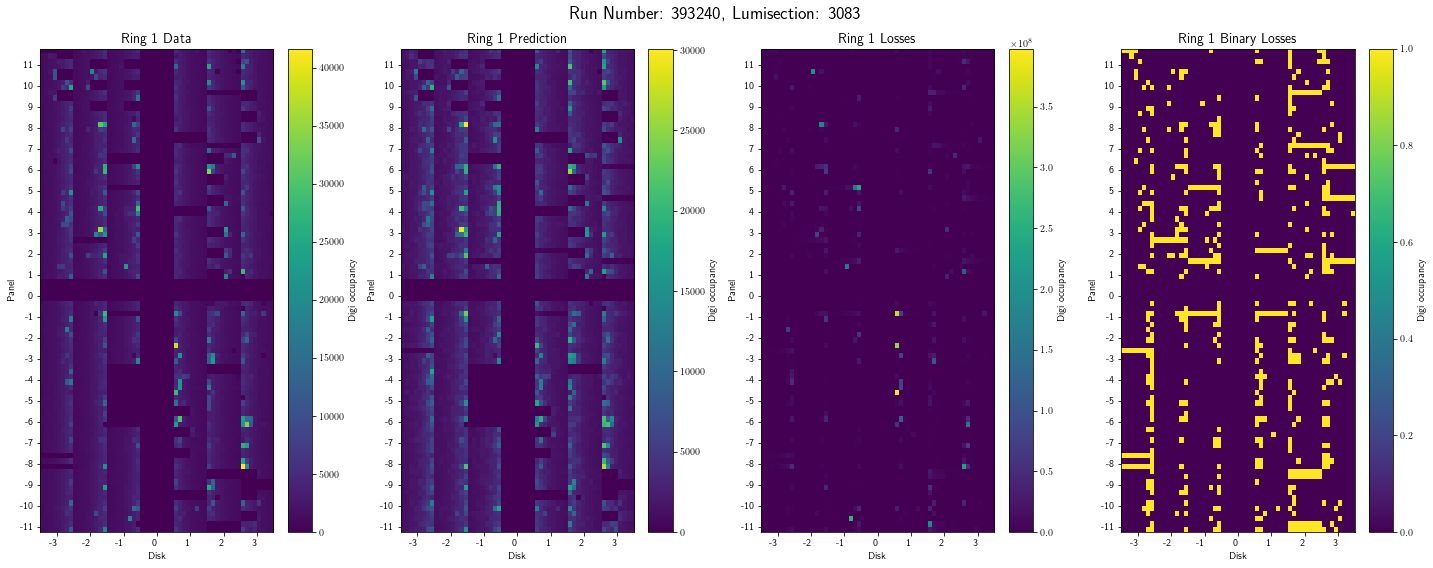

CPU times: user 1.6 s, sys: 454 ms, total: 2.06 s
Wall time: 5.7 s


In [16]:
%%time
#Inspect the original data, the prediction, the loss, and the binary loss
run_number = 393240
lumi_number = 3083
verbose = 1
save_fig = False

#Find the data_dict with a run number of run_number and extract the relevant information
#https://stackoverflow.com/questions/8653516/search-a-list-of-dictionaries-in-python. See here
plot_dict = next((data_dict for data_dict in data_dict_list if data_dict["run_number"] == run_number), None)
if plot_dict == None:
    raise Exception(f"Run Number {run_number} is not in the list of dictionaries!")

#Extract the relavant information for plotting
lumisections = plot_dict['lumisections']
if verbose>1: print(f"There are {len(lumisections)} Available Lumisections:\n{lumisections}")
multi_lumi_data = plot_dict['data_cross']
mes_pred_cross = plot_dict['predictions_cross']
losses_cross = plot_dict['losses']
losses_binary_cross = plot_dict['losses_binary']

#Extract the anomalous powergroups in that lumisection
anomalous_lumisections = plot_dict['anomalous_lumisections'] #anomalous_lumisections is a comprehensive list of anomalous lumisections, 
#Containing duplicates for lumisections with multiple anomalous powergroups
desired_lumi_indices = np.where(anomalous_lumisections == lumi_number)[0] #np.where needs this extra [0]
anomalous_powergroups = plot_dict['anomalous_powergroups']
desired_anomalous_powergroups = anomalous_powergroups[desired_lumi_indices]


#Extract the specific lumisection data
index = lumiToIndex(lumisections, lumi_number)
data = multi_lumi_data[index]
prediction = mes_pred_cross[index]
plot_losses = losses_cross[index]
plot_losses_binary = losses_binary_cross[index]
if verbose>0: print(f"All Anomalous Powergroups in This Lumisection: {desired_anomalous_powergroups}")


print(f"Run Number: {run_number}\tLumi Number: {lumi_number}")
testingFig, testingAxes = plot_testing_plots(data, prediction, plot_losses, 
                                             plot_losses_binary, run_number, lumi_number, ring_num, 
                                             saveFig=save_fig, showFig=True)

plt.show()

## Inspecting Specific Data Dictionaries

In [21]:
%%skip True
run_number = 393240
verbose = 1
show_fig = True
save_fig = True
save_directory = 'images'

inspect_dict = next((data_dict for data_dict in data_dict_list if data_dict["run_number"] == run_number), None)

print(inspect_dict["run_number"])
print(inspect_dict["lumisections"])
print(inspect_dict["data"].shape)

#Extract the relavant information for plotting
lumisections = inspect_dict['lumisections']
if verbose>1: print(f"There are {len(lumisections)} Available Lumisections:\n{lumisections}")
multi_lumi_data = inspect_dict['data_cross']
mes_pred_cross = inspect_dict['predictions_cross']
losses_cross = inspect_dict['losses']
losses_binary_cross = inspect_dict['losses_binary']

#Extract the anomalous powergroups in that lumisection
anomalous_lumisections = inspect_dict['anomalous_lumisections'] #anomalous_lumisections is a comprehensive list of anomalous lumisections, 
#Containing duplicates for lumisections with multiple anomalous powergroups

#Save all of the images for a specific length of lumisections and for a specific run for analyzing results more in-depth
#Useful for finding anomalies in training data that may not have been found
lumi_start = 3083
lumi_end = 3494
lumi_range = np.arange(lumi_start, lumi_end+1, 1) #Set up the range of lumis to plot
#Exclude lumis where we already know there is an anomaly and they have already been discarded from training
excluded_lumis = np.array([168, 169, 523, 524, 525, 526, 573, 574, 575, 576, 577, 578, 853, 854, 855, 856, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224 ,225 ,226 ,227 ,228 ,229 ,230 ,231 ,232 ,233 ,234 ,235 ,236 ,237 ,238 ])
# lumis_to_plot = [i for i in lumi_range if i not in excluded_lumis] #list comprehension way
#Numpy way
indices=np.argwhere(np.isin(lumi_range,excluded_lumis))
lumis_to_plot=np.delete(lumi_range,indices)
print(lumis_to_plot.shape)

for idx, lumisection in enumerate(lumis_to_plot):
    
    #Only plot every tenth lumisection
    if lumisection % 10 != 0:
        continue

    desired_lumi_indices = np.where(anomalous_lumisections == lumisection)[0] #np.where needs this extra [0]
    anomalous_powergroups = inspect_dict['anomalous_powergroups']
    desired_anomalous_powergroups = anomalous_powergroups[desired_lumi_indices]


    #Extract the specific lumisection data
    try:
        index = lumiToIndex(lumisections, lumisection)
    except:
        print(f"ERROR: Desired Lumisection {lumisection} not found in lumisection array!")
        continue
    data = multi_lumi_data[index]
    prediction = mes_pred_cross[index]
    plot_losses = losses_cross[index]
    plot_losses_binary = losses_binary_cross[index]
    if verbose>0: print(f"All Anomalous Powergroups in This Lumisection: {desired_anomalous_powergroups}")


    print(f"Run Number: {run_number}\tLumi Number: {lumisection}")
    testingFig, testingAxes = plot_testing_plots(data, prediction, plot_losses, 
                                                 plot_losses_binary, run_number, lumisection, ring_num, 
                                                 saveFig=save_fig, showFig=show_fig, directory=save_directory)

    plt.show()